Практическая работа № 4

Выполнил студент группы ББМО-01-23: Панков.Н.О

Цель работы:

1. Загрузить ранее обученную модель на датасете MNIST.
2. Изучить теоретические основы атаки DeepFool.
3. Реализовать атаку DeepFool с помощью фреймворка Foolbox.
4. Оценить точность модели на противоречивых примерах и сравнить с результатами на обычных
данных.

In [1]:
# Установка библеотеки foolbox
!pip install foolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.2 MB/s eta 0:00:00


In [2]:
# Импорт всех необходимых бибилеотек
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import foolbox as fb
import matplotlib.pyplot as plt

In [4]:
# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
test_images = test_images / 255.0

# Преобразование меток в формат one-hot
test_labels = to_categorical(test_labels, num_classes=10)

# Загрузка обученной модели
model = tf.keras.models.load_model('mnist_model.h5')

# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9723 - loss: 0.0974
Test accuracy on clean images: 0.9764000177383423


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


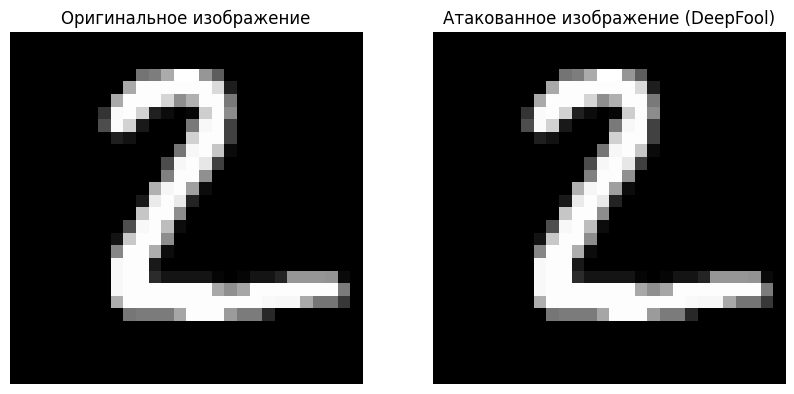

In [5]:
# Инициализация модели для Foolbox
fmodel = fb.TensorFlowModel(model, bounds=(-1, 1))

# Подготовка изображения и метки
image = tf.convert_to_tensor(test_images[1][None, ...], dtype=tf.float32)  # Добавляем размерность батча
label = tf.convert_to_tensor(np.argmax(test_labels[0]), dtype=tf.int64)  # Получаем и преобразуем метку

# Выполнение атаки DeepFool
attack = fb.attacks.L2DeepFoolAttack(steps=10)
advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)

# Вывод оригинального и атакованного изображений
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].set_title("Оригинальное изображение")
axes[0].imshow(image[0].numpy(), cmap="gray")
axes[0].axis('off')
axes[1].set_title("Атакованное изображение (DeepFool)")
axes[1].imshow(advs[0].numpy(), cmap="gray")
axes[1].axis('off')
plt.show()

In [6]:
# Обработка всех изображений и генерация противоречивых примеров
adversarial_images = [
    attack(fmodel, tf.convert_to_tensor(img, dtype=tf.float32)[None, ...],
           tf.convert_to_tensor(np.argmax(lbl), dtype=tf.int64)[None],
           epsilons=0.01)[0]
    for img, lbl in zip(test_images, test_labels)
]

# Конкатенация и оценка точности
adversarial_images = tf.concat(adversarial_images, axis=0)
_, adversarial_acc = model.evaluate(adversarial_images, test_labels)
print(f'Точность на состязательных примерах (DeepFool): {adversarial_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: 138.0141
Точность на состязательных примерах (DeepFool): 0.0


Вывод:

Точность модели на атакованных примерах снизилась до 0%. Это резкое падение указывает на неспособность модели корректно классифицировать изображения, содержащие целенаправленные искажения, даже если они минимальны. Результат подчеркивает уязвимость модели к подобным атакам и необходимость разработки более устойчивых подходов, способных противостоять таким воздействиям. Усиление устойчивости к атакам позволит улучшить надёжность модели в реальных приложениях, особенно в тех, где важна защита от манипуляций и высокая точность распознавания.